In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import logging
import datetime

from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer, LabelEncoder
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from xgboost import plot_importance
from mlxtend.preprocessing import DenseTransformer
from mlxtend.feature_selection import ColumnSelector
from itertools import product

sns.set(color_codes=True)

In [2]:
logger = logging.getLogger('ai')
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s  %(filename)s : %(levelname)s  %(message)s')

# Features Engineering

## outliers

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_df = pd.read_csv('../input/sales_train.csv', parse_dates = ['date'], date_parser=dateparse)

In [4]:
item_df = pd.read_csv('../input/items.csv')
shop_df = pd.read_csv('../input/shops.csv')
category_df = pd.read_csv('../input/item_categories.csv')

In [5]:
test_df = pd.read_csv('../input/test.csv').set_index('ID')

### Clear the data out of range

In [6]:
logger.info("item_price more than 100000 is %d" % sales_df[sales_df.item_price > 100000].shape[0])
logger.info("item_cnt_day more than 1000 is %d" % sales_df[sales_df.item_cnt_day > 1000].shape[0])

2019-02-16 12:25:26,969  <ipython-input-6-ea685e07fb41> : INFO  item_price more than 100000 is 1
2019-02-16 12:25:26,974  <ipython-input-6-ea685e07fb41> : INFO  item_cnt_day more than 1000 is 1


In [7]:
sales_df = sales_df[sales_df.item_price<100000]
sales_df = sales_df[sales_df.item_cnt_day<1000]

### Correct the negative item price

In [8]:
sales_df[sales_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [9]:
sales_df.at[484683, 'item_price'] = sales_df[(sales_df.item_id == 2973) & (sales_df.item_price > 0)].item_price.mean()

### Adjust duplicates by shop name

According to the reference, some shops are duplicates. This feature found is based on the language background.

In [10]:
shop_df[shop_df.shop_id == 0]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [11]:
shop_df[shop_df.shop_id == 57]

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57


The shop_id 0 and 57 are the same shop. And other pairs are 1 and 58, 10 and 11.

In [12]:
# Якутск Орджоникидзе, 56
sales_df.at[sales_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_df.at[sales_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_df.at[sales_df.shop_id == 10, 'shop_id'] = 11

## Extract Features

In [13]:
def _rename(prefix):
    cols = ['2013-01', '2013-02', '2013-03', '2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12','2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08', '2015-09','2015-10']
    
    result = {}
    for i in range(1, len(cols) + 1, 1):
        result[cols[i-1]] = prefix + str(i)
    
    return result

+ **Feature 'r' series**: Sales record

In [14]:
t = sales_df.groupby([sales_df.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).agg({'item_cnt_day': 'sum'}).reset_index()

t = t[['date','item_id','shop_id','item_cnt_day']]
t = t.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()
t = t.rename(index=str, columns=_rename('r'))

+ **Feature 'p' series**: Sale price record

In [15]:
p = sales_df.groupby([sales_df.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).agg({'item_price': 'mean'}).reset_index()

p = p[['date','item_id','shop_id', 'item_price']]
p = p.pivot_table(index=['item_id','shop_id'], columns='date',values='item_price',fill_value=0).reset_index()
p = p.rename(index=str, columns=_rename('p'))

In [16]:
sales_detail_df = pd.merge(t, p, on=['item_id','shop_id'], how='left')

In [17]:
def _extract(df, i, is_test=False):
    arr = ['item_id','shop_id']
    for j in range(1, 13, 1):
        arr = arr + ['r' + str(i-j)]
        arr = arr + ['p' + str(i-j)]
    
    if not is_test:
        arr = arr + ['r' + str(i)]
    
    tdf = df[arr]
    tdf['date_block_num'] = i - 1
    
    return tdf

In [18]:
cols = ['item_id','shop_id', 'r1', 'p1', 'r2', 'p2', 'r3', 'p3', 'r4', 'p4', 'r5', 'p5', 'r6', 'p6', 'r7', 'p7', 'r8', 'p8', 'r9', 'p9', 'r10', 'p10', 'r11', 'p11', 'r12', 'p12','item_cnt_month', 'date_block_num']
sales_record_df = pd.DataFrame(columns=cols)
for i in range(13, 35, 1):
    tdf = _extract(sales_detail_df, i)
    sales_record_df = sales_record_df.append(pd.DataFrame(columns=cols, data=tdf.values))

/Users/leewind/.local/share/virtualenvs/leewind-p6XO93Th/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [19]:
sales_record_df[(sales_record_df.shop_id == 54) & (sales_record_df.item_id == 2)].head(20)

,item_id,shop_id,r1,p1,r2,p2,r3,p3,r4,p4,...,r9,p9,r10,p10,r11,p11,r12,p12,item_cnt_month,date_block_num
2,2.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2,2.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
2,2.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
2,2.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
2,2.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
2,2.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
2,2.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
2,2.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.0
2,2.0,54.0,1.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
2,2.0,54.0,0.0,0.0,1.0,58.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0


In [20]:
sales_record_df['item_id'] = sales_record_df['item_id'].astype(int)
sales_record_df['shop_id'] = sales_record_df['shop_id'].astype(int)

In [21]:
sales_record_df['month'] = sales_record_df['date_block_num'].apply(lambda x: (x % 12) + 1)

+ **Feature 'city'**: Each shop_name starts with the city name.

In [22]:
shop_df.loc[shop_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shop_df['shop_name'] = shop_df['shop_name'].astype(str)
shop_df['city'] = shop_df['shop_name'].str.split(' ').map(lambda x: x[0])
shop_df.loc[shop_df.city == '!Якутск', 'city'] = 'Якутск'

encoder = LabelEncoder()
encoder.fit(shop_df['city'])
shop_df['city_code'] = encoder.transform(shop_df['city'])

+ **Feature 'type'**: Each category contains type and subtype in its name.
+ **Feature 'subtype'**: Each category contains type and subtype in its name.

In [23]:
category_df['item_category_name'] = category_df['item_category_name'].astype(str)
category_df['type'] = category_df['item_category_name'].map(lambda x: x.split('-')[0].strip())

encoder = LabelEncoder()
encoder.fit(category_df['type'])
category_df['type_code'] = encoder.transform(category_df['type'])

In [24]:
category_df['subtype'] = category_df['item_category_name'].map(lambda x: x.split('-')[1].strip() if len(x.split('-')) > 1 else x.split('-')[0].strip())

encoder = LabelEncoder()
encoder.fit(category_df['subtype'])
category_df['subtype_code'] = encoder.transform(category_df['subtype'])

## Merge Data into one entity

In [25]:
sales_record_df = pd.merge(sales_record_df, item_df, on=['item_id'], how='left')
sales_record_df = pd.merge(sales_record_df, shop_df, on=['shop_id'], how='left')
sales_record_df = pd.merge(sales_record_df, category_df, on=['item_category_id'], how='left')

In [26]:
sales_record_df.head()

,item_id,shop_id,r1,p1,r2,p2,r3,p3,r4,p4,...,item_name,item_category_id,shop_name,city,city_code,item_category_name,type,type_code,subtype,subtype_code
0,0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,"Химки ТЦ ""Мега""",Химки,26,Кино - DVD,Кино,11,DVD,4
1,1,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,!ABBYY FineReader 12 Professional Edition Full...,76,Цифровой склад 1С-Онлайн,Цифровой,27,Программы - Для дома и офиса (Цифра),Программы,15,Для дома и офиса (Цифра),31
2,2,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,***В ЛУЧАХ СЛАВЫ (UNV) D,40,"Химки ТЦ ""Мега""",Химки,26,Кино - DVD,Кино,11,DVD,4
3,3,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,***ГОЛУБАЯ ВОЛНА (Univ) D,40,"Химки ТЦ ""Мега""",Химки,26,Кино - DVD,Кино,11,DVD,4
4,4,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,***КОРОБКА (СТЕКЛО) D,40,"Химки ТЦ ""Мега""",Химки,26,Кино - DVD,Кино,11,DVD,4


In [27]:
sales_record_df = sales_record_df.drop(['city', 'type', 'subtype', 'item_name', 'shop_name', 'item_category_name'], axis=1)

In [28]:
for i in range(1, 13, 1):
    t = sales_record_df.groupby(['shop_id', 'item_category_id'])['r'+str(i)].mean().reset_index(name='sc'+str(i))
    sales_record_df = pd.merge(sales_record_df, t, on=['shop_id', 'item_category_id'], how='left')

## Feature Selection

In [29]:
dataset = sales_record_df.copy()

In [30]:
dataset.columns.values

array(['item_id', 'shop_id', 'r1', 'p1', 'r2', 'p2', 'r3', 'p3', 'r4',
       'p4', 'r5', 'p5', 'r6', 'p6', 'r7', 'p7', 'r8', 'p8', 'r9', 'p9',
       'r10', 'p10', 'r11', 'p11', 'r12', 'p12', 'item_cnt_month',
       'date_block_num', 'month', 'item_category_id', 'city_code',
       'type_code', 'subtype_code', 'sc1', 'sc2', 'sc3', 'sc4', 'sc5',
       'sc6', 'sc7', 'sc8', 'sc9', 'sc10', 'sc11', 'sc12'], dtype=object)

In [31]:
dataset_beta = dataset[dataset.date_block_num == 32]
dataset_alpha = dataset[dataset.date_block_num == 33]

In [32]:
continuous = [
        'item_id', 'shop_id', 'r1', 'p1', 'r2', 'p2', 'r3', 'p3', 'r4',
       'p4', 'r5', 'p5', 'r6', 'p6', 'r7', 'p7', 'r8', 'p8', 'r9', 'p9',
       'r10', 'p10', 'r11', 'p11', 'r12', 'p12',
       'date_block_num', 'month', 'item_category_id', 'city_code',
       'type_code', 'subtype_code','sc1', 'sc2', 'sc3', 'sc4', 'sc5',
       'sc6', 'sc7', 'sc8', 'sc9', 'sc10', 'sc11', 'sc12'
]

fields = [
    
]

label = ['item_cnt_month']

len(continuous)

44

In [34]:
features_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnSelector(continuous)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('normalize', Normalizer())
        ])),
    ])),
])

features_pipeline.fit(dataset_beta, dataset_beta[label].values.ravel())

train_dataset_x = features_pipeline.transform(dataset_beta)
train_dataset_y = dataset_beta[label].values.ravel()

valid_dataset_x = features_pipeline.transform(dataset_alpha)
valid_dataset_y = dataset_alpha[label].values.ravel()

In [35]:
selector_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=0)
selector_model.fit(train_dataset_x, train_dataset_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [36]:
thresh = 0.001
selection = SelectFromModel(selector_model, threshold=thresh, prefit=True)

train_dataset_x = selection.transform(train_dataset_x)
valid_dataset_x = selection.transform(valid_dataset_x)

In [37]:
selector_model.feature_importances_

array([0.14979339, 0.05096419, 0.10967631, 0.04924243, 0.04269972,
       0.0137741 , 0.02961433, 0.01222452, 0.03099173, 0.01652892,
       0.01687328, 0.01584022, 0.01274105, 0.00533747, 0.0101584 ,
       0.00189394, 0.00809229, 0.00241047, 0.01170799, 0.00327135,
       0.00688705, 0.00172176, 0.00568182, 0.00172176, 0.0094697 ,
       0.00172176, 0.09004821, 0.        , 0.03856749, 0.01170799,
       0.01893939, 0.0225551 , 0.08746556, 0.02066116, 0.00792011,
       0.01033058, 0.00723141, 0.01119146, 0.01256887, 0.00568182,
       0.00516529, 0.00723141, 0.00895317, 0.01274105], dtype=float32)

In [38]:
feature_selector = []
for index, value in enumerate(selector_model.feature_importances_):
    if value > 0 and index < len(continuous):
        feature_selector.append((continuous[index], value))

feature_selector

[('item_id', 0.14979339),
 ('shop_id', 0.050964188),
 ('r1', 0.10967631),
 ('p1', 0.049242426),
 ('r2', 0.042699724),
 ('p2', 0.013774104),
 ('r3', 0.029614326),
 ('p3', 0.012224518),
 ('r4', 0.030991735),
 ('p4', 0.016528925),
 ('r5', 0.016873278),
 ('p5', 0.015840221),
 ('r6', 0.012741047),
 ('p6', 0.0053374656),
 ('r7', 0.010158402),
 ('p7', 0.0018939395),
 ('r8', 0.008092286),
 ('p8', 0.0024104684),
 ('r9', 0.011707989),
 ('p9', 0.00327135),
 ('r10', 0.006887052),
 ('p10', 0.001721763),
 ('r11', 0.0056818184),
 ('p11', 0.001721763),
 ('r12', 0.009469697),
 ('p12', 0.001721763),
 ('date_block_num', 0.09004821),
 ('item_category_id', 0.038567495),
 ('city_code', 0.011707989),
 ('type_code', 0.018939395),
 ('subtype_code', 0.022555096),
 ('sc1', 0.08746556),
 ('sc2', 0.020661157),
 ('sc3', 0.007920111),
 ('sc4', 0.010330578),
 ('sc5', 0.007231405),
 ('sc6', 0.01119146),
 ('sc7', 0.012568871),
 ('sc8', 0.0056818184),
 ('sc9', 0.005165289),
 ('sc10', 0.007231405),
 ('sc11', 0.008953168)

2019-02-16 12:36:53,880  _base.py : DEBUG  update_title_pos
2019-02-16 12:36:53,896  font_manager.py : DEBUG  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2019-02-16 12:36:53,919  font_manager.py : DEBUG  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2019-02-16 12:36:54,024  font_manager.py : DEBUG  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2019-02-16 12:36:54,073  _base.py : DEBUG  update_title_pos
2019-02-16 12:36:54,335  _base.py : DEBUG  update_title_pos
2019-02-16 12:36:54,493  _base.py : DEBUG  update_title_pos
2019-02-16 12:36:54,589  _base.py : DEBUG  update_title_pos


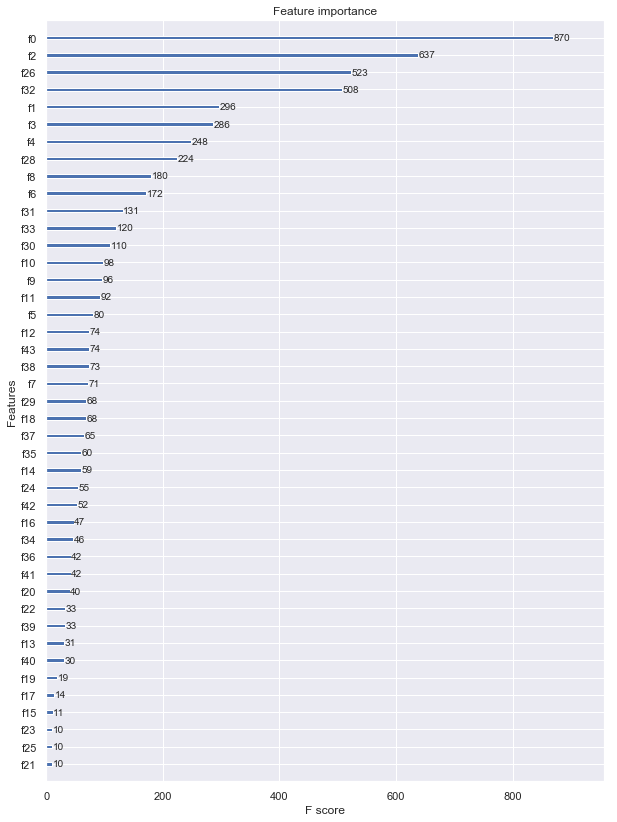

In [39]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(selector_model, (10,14))

## Train

In [92]:
START_NUM = 28
END_NUM = 31

In [ ]:
import xgboost as xgb

valid_dmatrix = xgb.DMatrix(valid_dataset_x, label=valid_dataset_y)

for i in range(START_NUM, END_NUM, 1):
    print('round %d' % i)

    dataset_beta = dataset[dataset.date_block_num == i]
    
    train_dataset_x = features_pipeline.transform(dataset_beta)
    train_dataset_x = selection.transform(train_dataset_x)
    
    train_dataset_y = dataset_beta[label].values.ravel()
    
    train_dmatrix = xgb.DMatrix(train_dataset_x, label=train_dataset_y)
    
    watchlist = [(train_dmatrix, 'train'), (valid_dmatrix, 'validate')] 
    
    if i != 12:
        params = {
            'objective': 'reg:linear', 
            'verbose': False,
            'eta': 0.1,
            'max_depth': 12,
            'min_child_weight': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'colsample_bylevel': 0.8,
            'eval_metric': 'rmse',
#             'process_type': 'update',
#             'updater'     : 'refresh',
#             'refresh_leaf': True,
#             'gamma': 0.01
        }
        
        model = xgb.train(params, train_dmatrix, num_boost_round=1000, early_stopping_rounds=50, evals=watchlist, xgb_model='xgb.model')
        
        if model.best_score > best_score:
            best_score = model.best_score
            model.save_model('xgb.model')
        
    else:
        
        params = {
            'objective': 'reg:linear', 
            'verbose': False,
            'eta': 0.1,
            'max_depth': 12,
            'min_child_weight': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'colsample_bylevel': 0.8,
            'eval_metric': 'rmse',
        }
        model = xgb.train(params, train_dmatrix, num_boost_round=1000, early_stopping_rounds=50, evals=watchlist)
        best_score = model.best_score
    
        model.save_model('xgb.model')

In [94]:
from sklearn.metrics import mean_squared_error
from math import sqrt

model = xgb.Booster({'nthread':4}) #init model
model.load_model("xgb.model") # load data

pred = model.predict(valid_dmatrix)

sqrt(mean_squared_error(valid_dataset_y, pred))

1.6235795329696765

## Predict

In [95]:
model = xgb.Booster({'nthread':4}) #init model
model.load_model("xgb.model") # load data

tdf = _extract(sales_detail_df, 35, is_test=True)
dataset_predict = pd.merge(test_df, tdf, on=['item_id', 'shop_id'], how='left')

predict_dataset_x = features_pipeline.transform(dataset_predict)
predict_dataset_x = selection.transform(predict_dataset_x)

predict_dmatrix = xgb.DMatrix(predict_dataset_x)

pred = model.predict(predict_dmatrix)

/Users/leewind/.local/share/virtualenvs/leewind-p6XO93Th/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/leewind/.local/share/virtualenvs/leewind-p6XO93Th/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [96]:
submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": pred
})

submission.to_csv('submission.csv', index=False)

# Reference

## Normal ML Analysis

+ [Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)
+ [Predicting sales using Lightgbm](https://www.kaggle.com/sanket30/predicting-sales-using-lightgbm)

## Time Series

对于revenge的预测很有帮助，但是对于单个店的单个商品而言没有实际的意义，这种预测方式的学习非常有益处

+ [AR(I)MA时间序列建模过程——步骤和python代码](https://www.jianshu.com/p/cced6617b423)
+ [python时间序列分析](http://www.cnblogs.com/foley/p/5582358.html)
+ [AR、MA及ARMA模型](https://zhuanlan.zhihu.com/p/22248464)
+ [Time Series with Python (ODSC) STA.ipynb](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)
+ [Getting Started with Time Series](https://pyflux.readthedocs.io/en/latest/getting_started.html)
+ [Welcome to Statsmodels’s Documentation](http://www.statsmodels.org/devel/index.html)